# How to use `wellfit`

**NOTE: `wellfit` is under developement. This API is likely to change, and this tutorial may not have been updated recently.**

`wellfit` can fit a transit model using the `starry` package and `scipy.optimize`, to give you the transit parameters for your system. Let's look at the basics of how to use `wellfit`.

In [2]:
# Load wellfit
from wellfit import wellfit as wf
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import MPLSTYLE

plt.style.use(MPLSTYLE)
%load_ext autoreload
% autoreload 2

First we can make a `Star` object.

In [3]:
star = wf.Star()
star

Star: 1.0 solRad, 1.0 solMass, 5777.0 K

By default, `wellfit` has made a star with solar parameters. Note that all the parameters have **units**. These are done with the `astropy.units` model. We can look at all the properties with the `properties` attribute.

In [4]:
star.properties

,Value,Lower Bound,Upper Bound
radius,1.0 solRad,-0.1,0.1
mass,1.0 solMass,-0.1,0.1
temperature,5777.0 K,-500,500
limb_darkening,"[0.4, 0.26]",-0.1,0.1


We can make a `Planet` object too.

The `Star` class has bound attributes, which have some sane defaults if you don't set them. You can think of these as errors. In the future, when we try to fit these properties, the bounds will tell our optimizer how far around the initial value it should explore. If you make the bounds very large, the optimizer 1) will take a long time to find the correct answer 2) may not converge.

In [5]:
planet = wf.Planet(host=star)
planet

Planet: RpRs 0.01 , P 10.0 d, t0 0

This has made a planet on a 10 day period, with a $R_p/R_*$ value of 0.01. Note the planet needs a host. This allows us to build information such as $R_p/R_*$ and the semi major axis of the planet.


Planets have properties too.

In [6]:
planet.properties

,Value,Lower Bound,Upper Bound
rprs,0.01,-0.1,0.1
period,10.0 d,-0.0005,0.0005
t0,0,-1e-05,1e-05
inclination,90,-0.5,0
eccentricity,0,0,0.01


You can easily change the parameters of your planet.

In [7]:
planet.rprs = 0.001
planet.period = 20
planet.t0 = 0.1

In [8]:
planet

Planet: RpRs 0.001 , P 20, t0 0.1

`Star`s and `Planet`s are no good on their own. You have to combine them into a single system or `Model`.

In [9]:
model = wf.Model(host=star, planets=[planet])

In [10]:
model

Star: 1.0 solRad, 1.0 solMass, 5777.0 K
	Planet: RpRs 0.001 , P 20.0 d, t0 0.1

Above we've made a `Model` consisting of a host `Star` and one `Planet`. You can add another planet if you like.

In [11]:
planet2 = wf.Planet(host=star)

In [12]:
model = wf.Model(host=star, planets=[planet, planet2])

In [13]:
model

Star: 1.0 solRad, 1.0 solMass, 5777.0 K
	Planet: RpRs 0.001 , P 20.0 d, t0 0.1
	Planet: RpRs 0.01 , P 10.0 d, t0 0

Now that we have a model, let's see what it looks like.

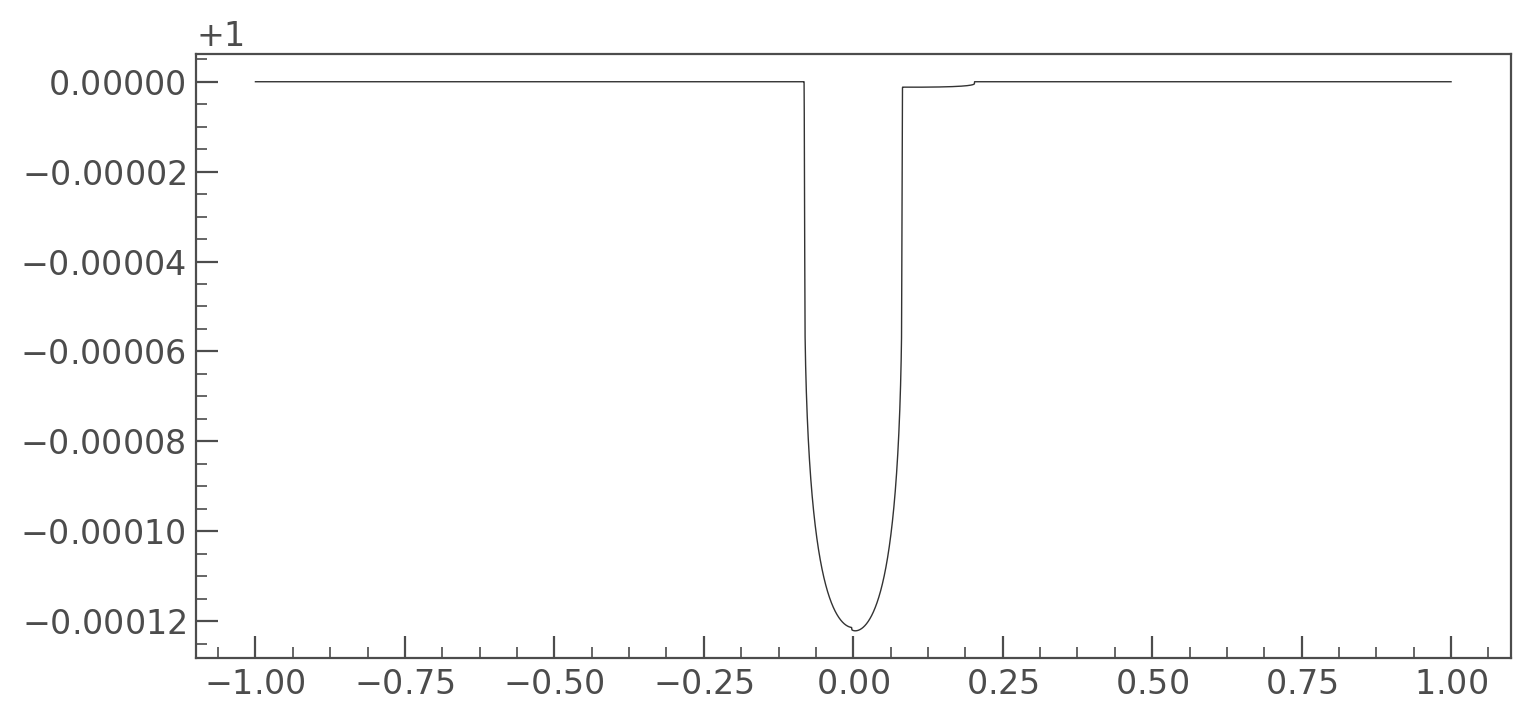

In [14]:
time = np.arange(-1, 1, 0.0001)
model.plot(time=time)

There are our two planets.

## Fitting with `wellfit`

`wellfit` is really about fitting actual transit data. Let's get some of that from Kepler.

In [15]:
from lightkurve import search_lightcurvefile

In [16]:
lc = search_lightcurvefile('Kepler-8', quarter=10).download().PDCSAP_FLUX.normalize().remove_nans()#.flatten(201)
lc.time += 2454833

Here's the data for Kepler-8b.

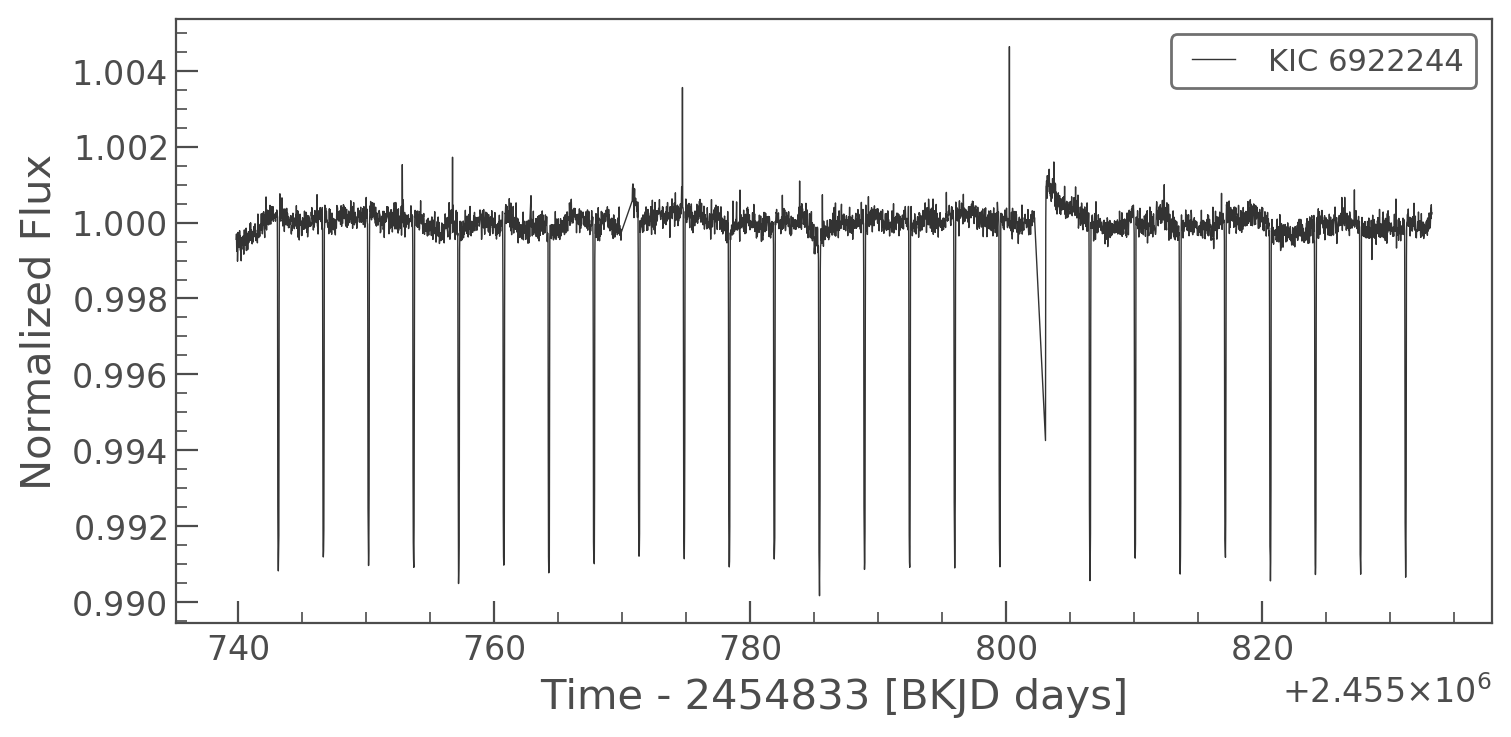

In [17]:
ax = lc.plot()

We now need to make our `wellfit` model. Instead of inputing values by hand, you can just grab the best fitting parameters from NexSci.

In [18]:
model = wf.Model.from_nexsci('Kepler-8')

Let's compute the flux and plot it.

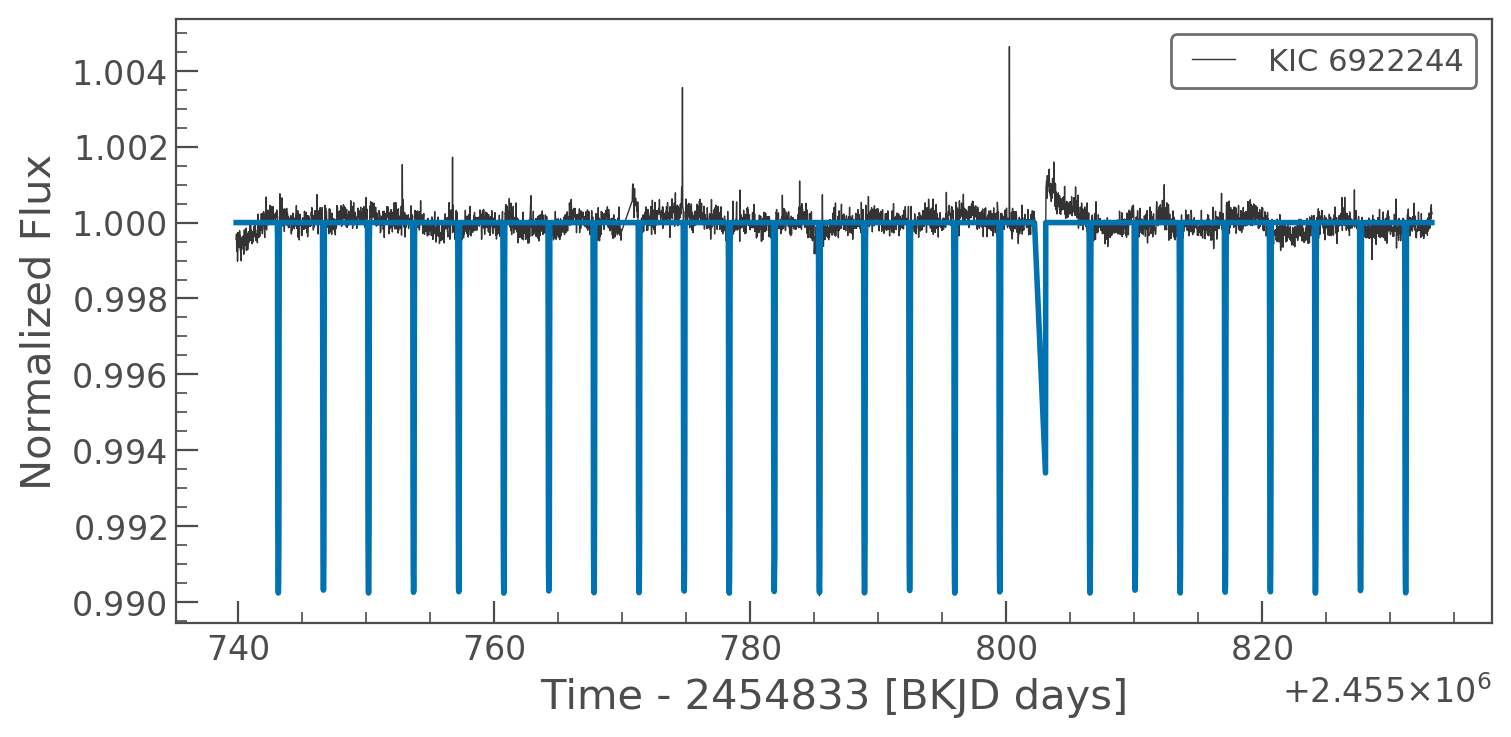

In [19]:
# Compute the flux
model_flux = model.compute(lc.time, lc.flux, lc.flux_err)

# Plot it
ax = lc.plot()
ax.plot(lc.time, model_flux, lw=2)

This already looks pretty great, but we've not fit anything yet. All we're doing is plotting the model from the NexSci properties. Let's look at those again

In [20]:
# Note we have to index into the model's planets...
model.planets[0].properties

,Value,Lower Bound,Upper Bound
rprs,0.097659,-0.0128281,0.010966
period,3.5224991 d,-2.1e-06,2.1e-06
t0,2.45495e+06,-6e-05,6e-05
inclination,83.978,-0.099,0.108
eccentricity,0,-0,0.01


We can visulize the errors on the values simply by using the `plot_bounds()` method.

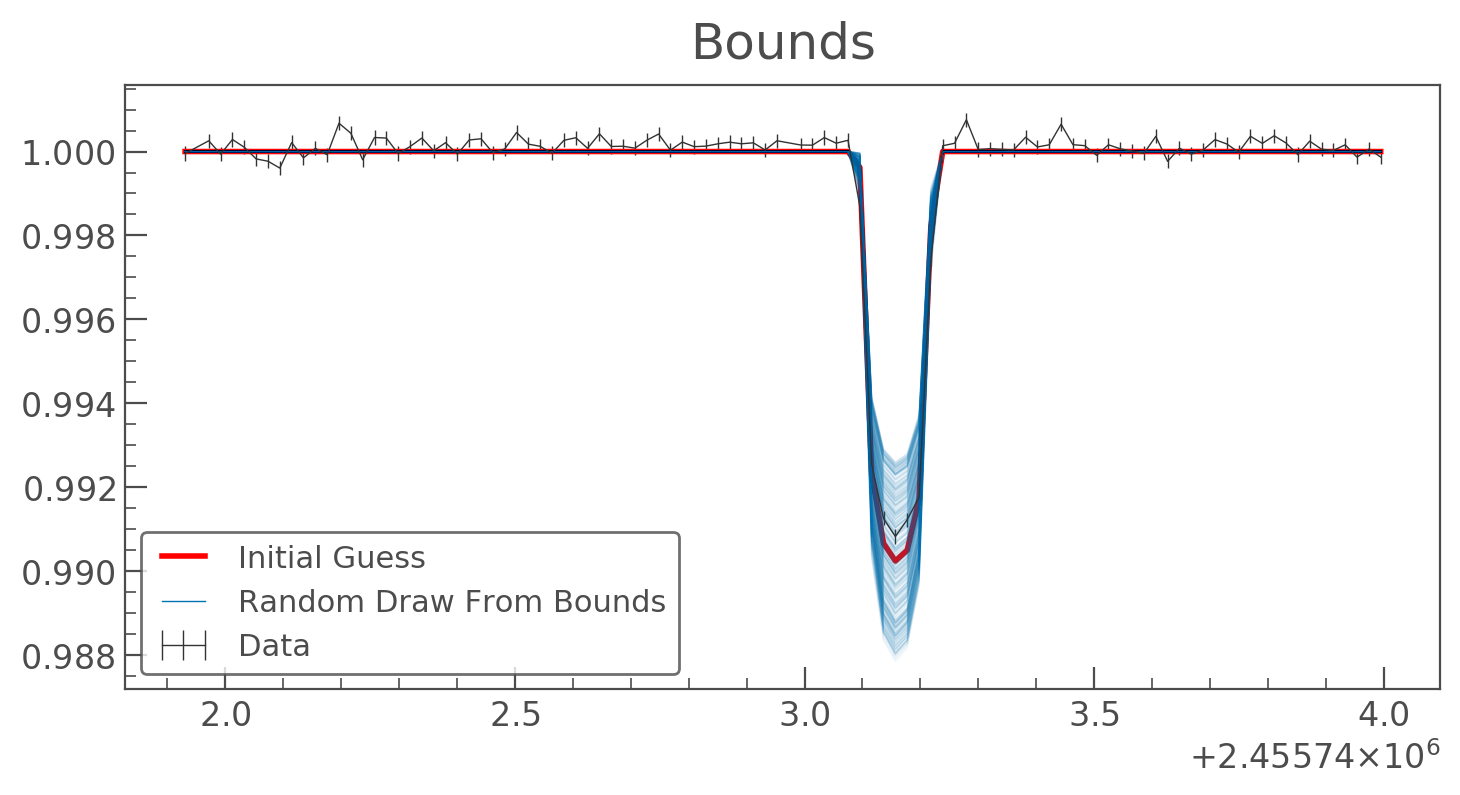

In [21]:
# I'm only plotting the first transit here
model.plot_bounds(time=lc.time[100:200], flux=lc.flux[100:200], flux_error=lc.flux_err[100:200])

It looks like those bounds are pretty tightly constrained to the transit. Let's make them a little wider.

In [22]:
# Increase the period bound by a fraction of a percent.
model.planets[0].period_error = (-model.planets[0].period.value*0.0001, model.planets[0].period.value*0.0001)

# Increase the transit mid point error by 15 minutes
model.planets[0].t0_error = (-0.01, 0.01)

# Increase the inclination bound by a few degrees
model.planets[0].inclination_error = (-5, 5)

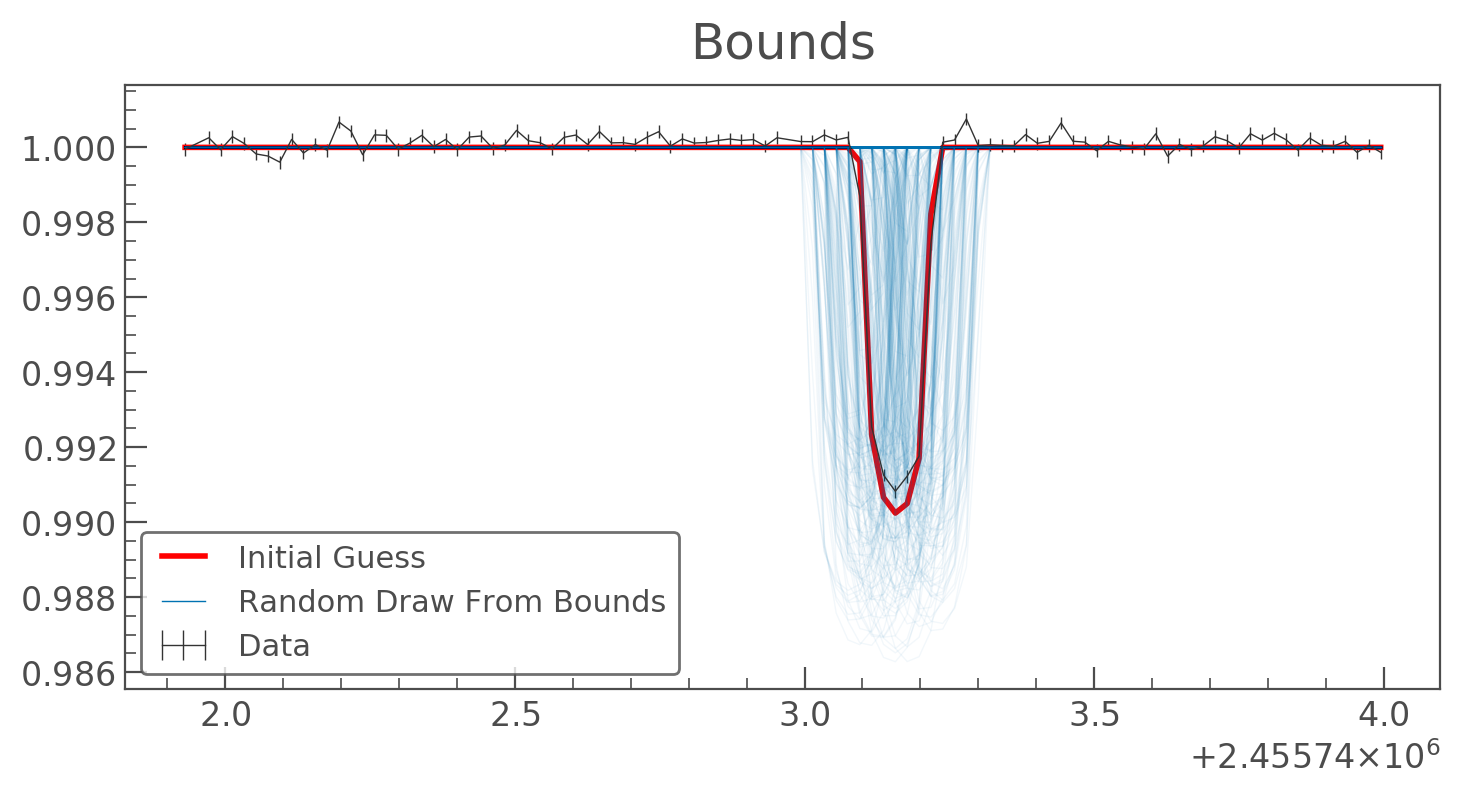

In [23]:
# I'm only plotting the first transit here
model.plot_bounds(time=lc.time[100:200], flux=lc.flux[100:200], flux_error=lc.flux_err[100:200])

The bounds are now much more forgiving and fully encompass the transit. Let's try fitting.

In [24]:
# This will take a few seconds
model.fit(time=lc.time, flux=lc.flux, flux_error=lc.flux_err, maxiter=500)

Let's take a look at the results!

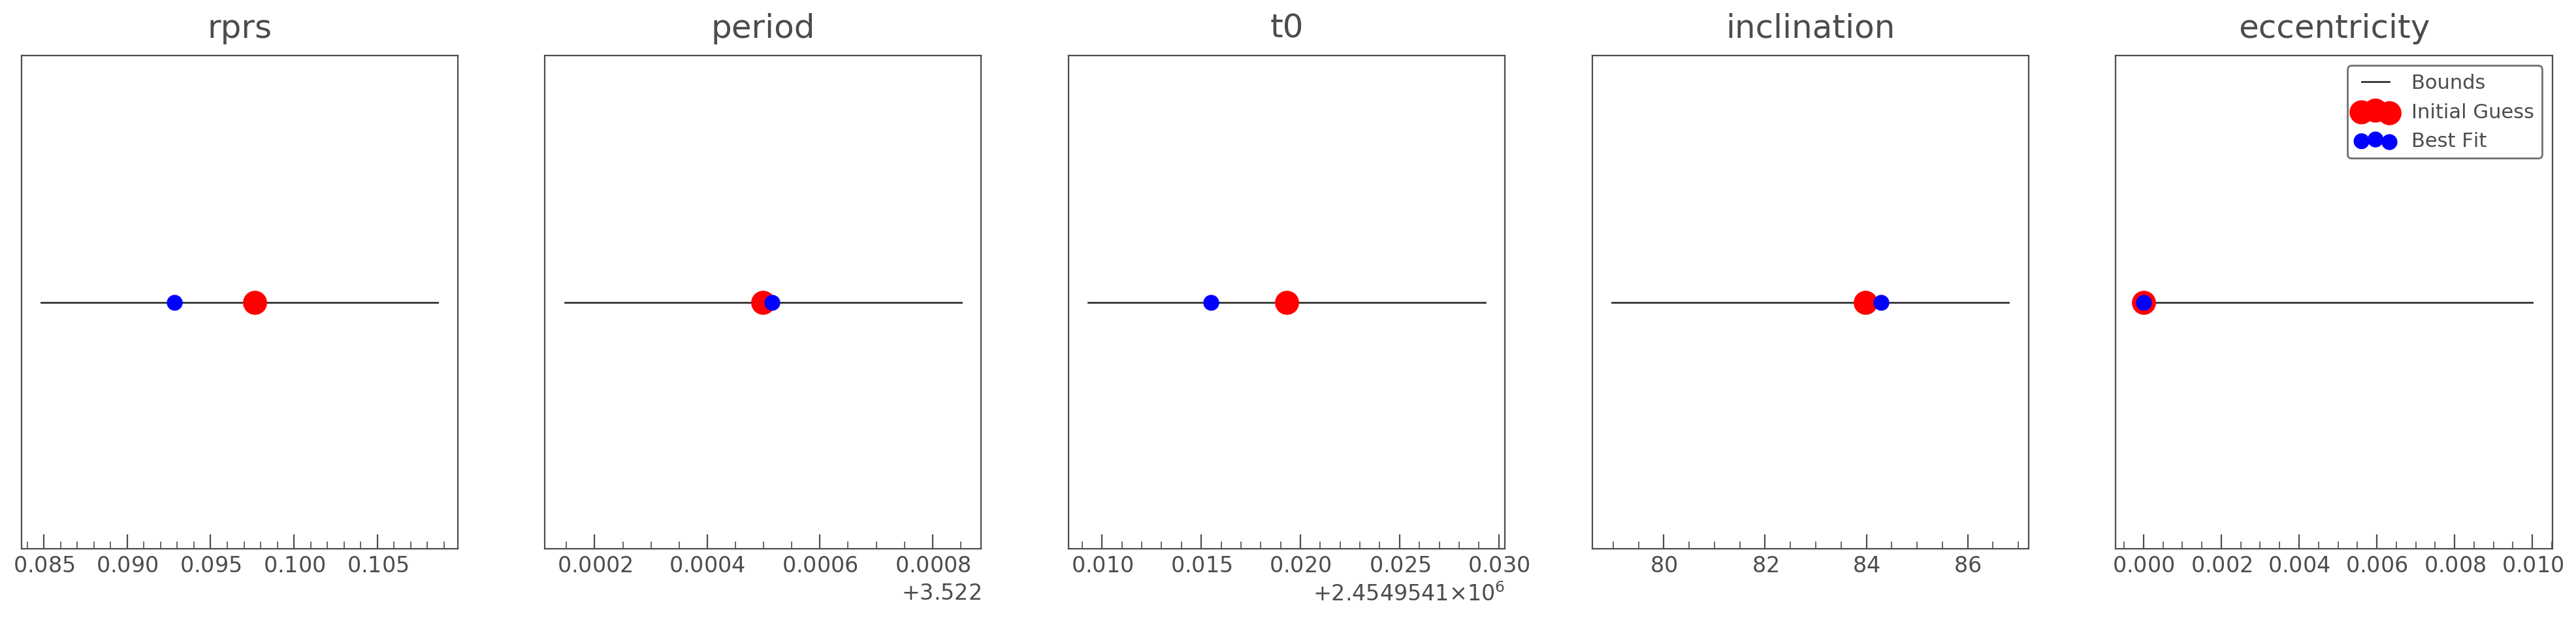

In [25]:
model.plot_results()

Looks like the fitter quite closely agrees with the with the initial guesses, although we find a smaller $R_p/R_s$. Let's plot up the final best fit model.

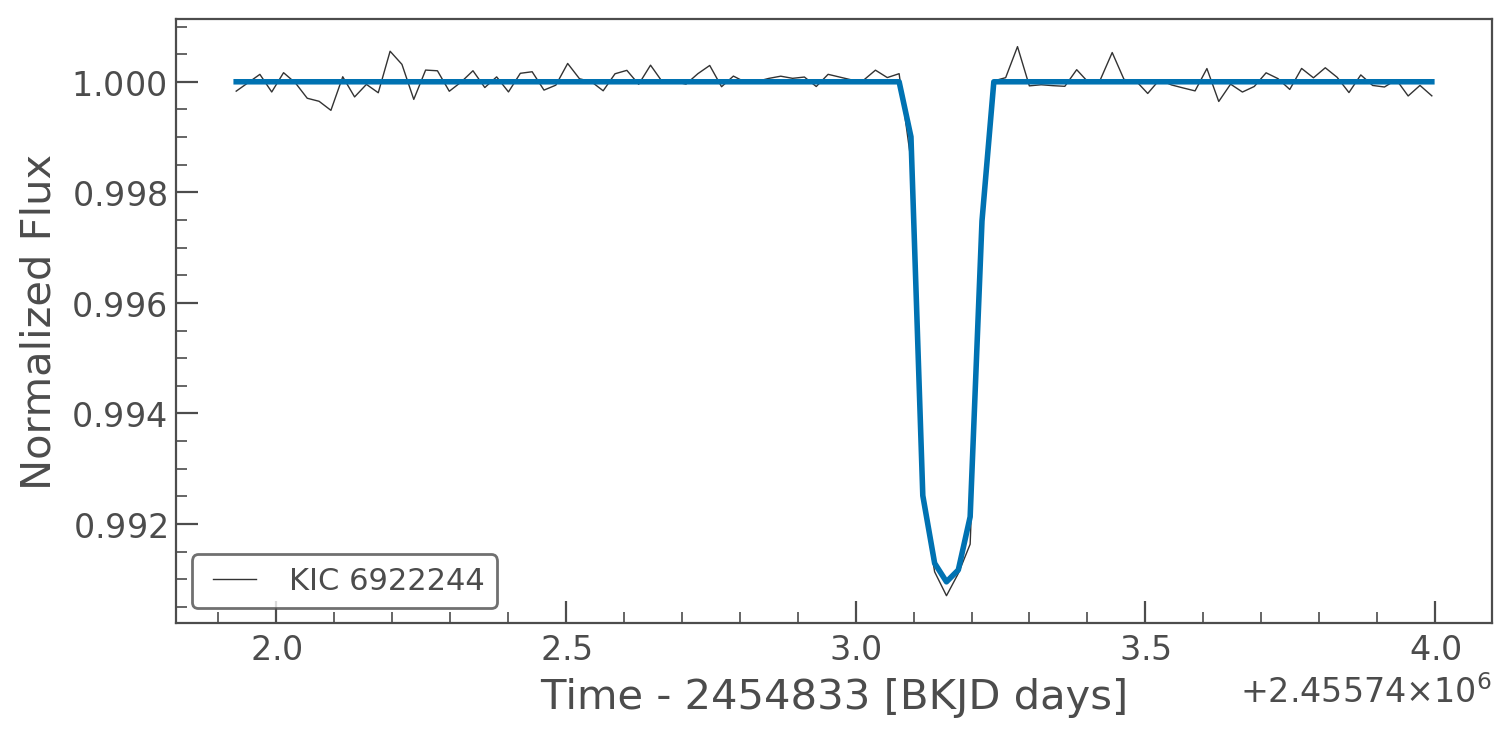

In [26]:
# Just the first transit again
ax = lc[100:200].plot()
ax.plot(lc[100:200].time, model.compute(lc[100:200].time), lw=2, label='Best Fit')

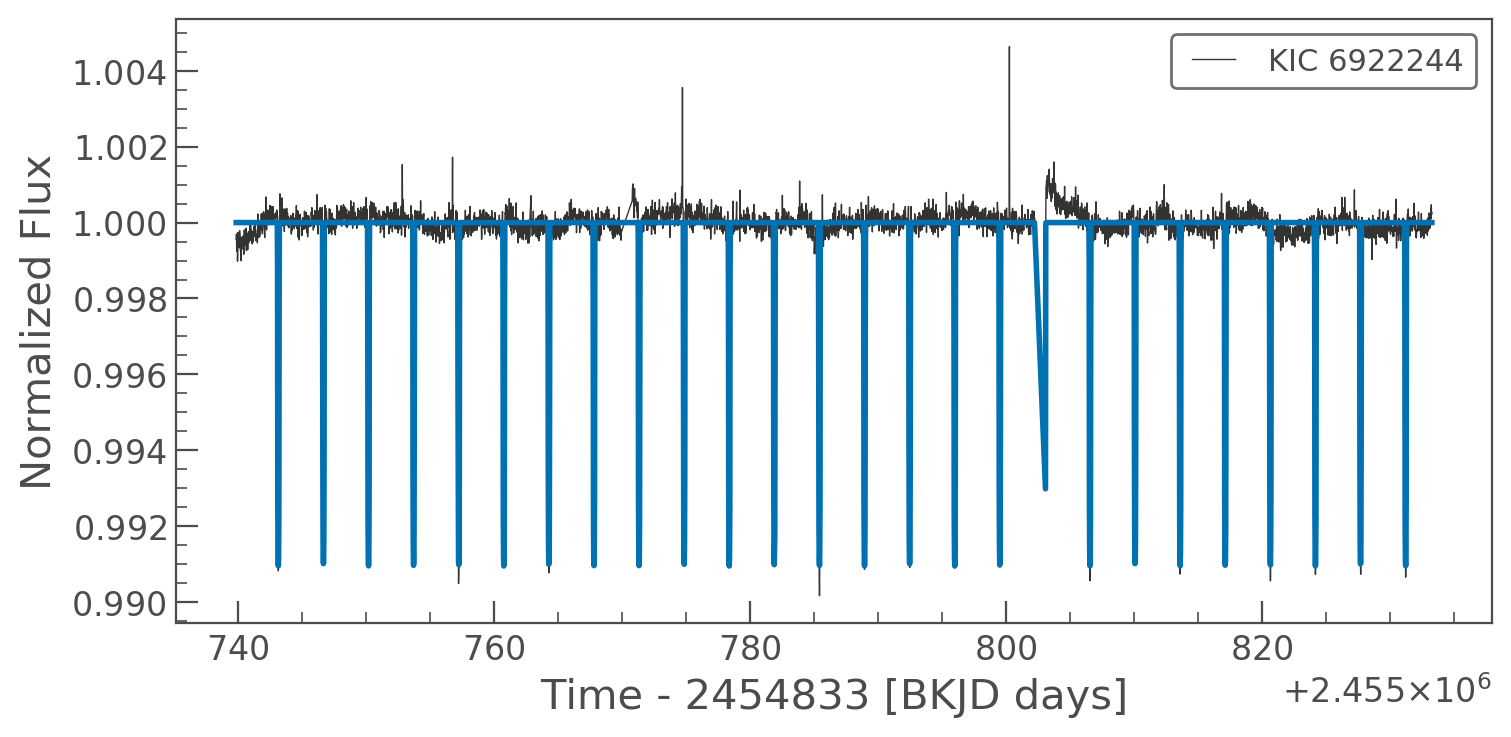

In [27]:
# The whole light curve
ax = lc.plot()
ax.plot(lc.time, model.compute(lc.time), lw=2, label='Best Fit')

# Adding in Gaussian Processes

You can do the same process above, but also add in a GP model for the long term trends. Currently we support a 2 term, Matern 3/2 kernel only. Start by initializing your model, but this time turn on GPs.

In [28]:
model = wf.Model.from_nexsci('Kepler-8', use_gps=True)

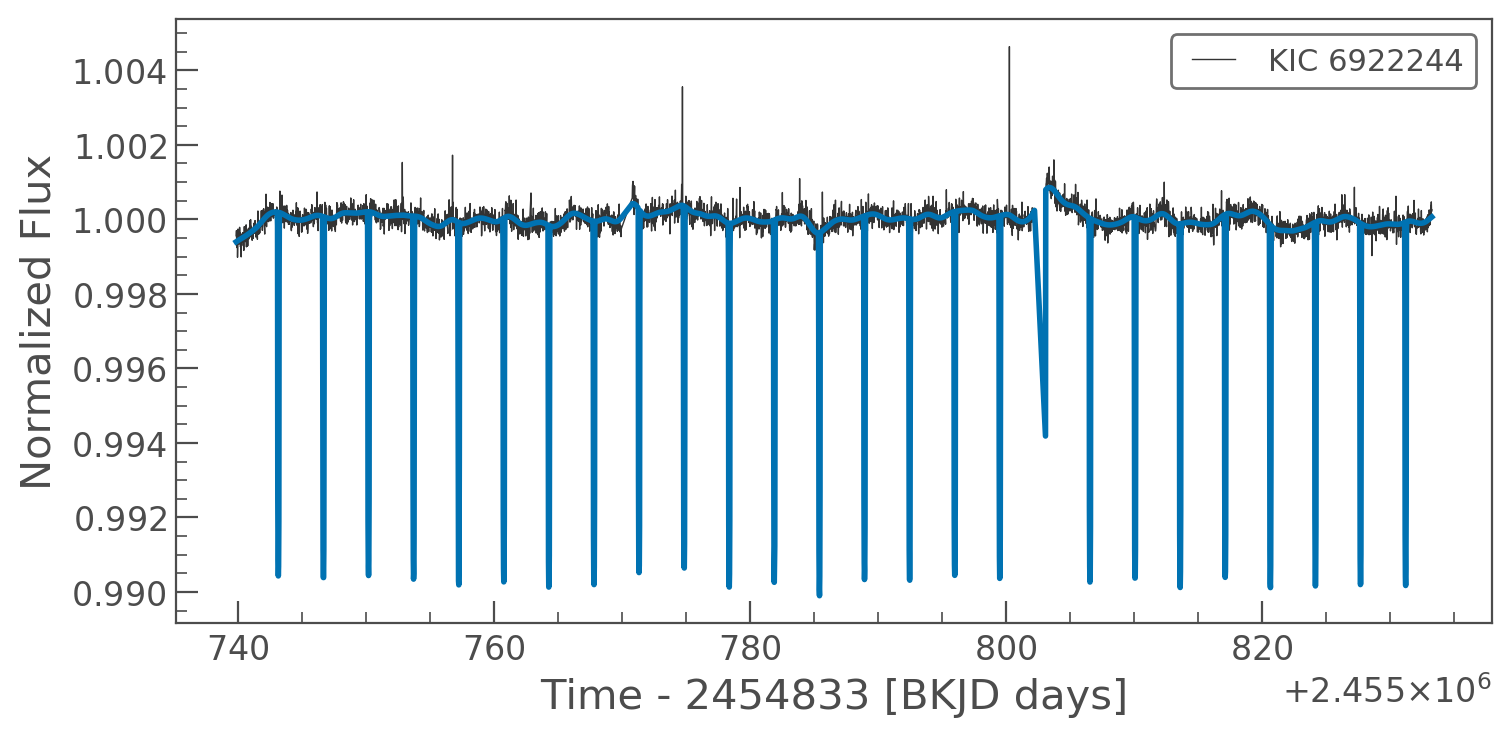

In [29]:
# Compute the flux
model_flux = model.compute(lc.time, lc.flux, lc.flux_err)

# Plot it
ax = lc.plot()
ax.plot(lc.time, model_flux, lw=2)

Now you can see that the long term trends are being fit in our data by our Gaussian Process. Now we need to fit both our **transit parameters** and our **Gaussian Process hyper parameters**. You can still do that with the simple fit command. 

First let's increase our bounds again

In [30]:
# Increase the period bound by a fraction of a percent.
model.planets[0].period_error = (-model.planets[0].period.value*0.0001, model.planets[0].period.value*0.0001)

# Increase the transit mid point error by 15 minutes
model.planets[0].t0_error = (-0.01, 0.01)

# Increase the inclination bound by a few degrees
model.planets[0].inclination_error = (-5, 5)

And so that we can see what the fit is doing, let's turn on some info logging for wellfit.

In [31]:
wf.log.setLevel('INFO')

In [32]:
# This will take a few minutes
model.fit(time=lc.time, flux=lc.flux, flux_error=lc.flux_err, maxiter=500)

scipy.minimize fit
------------------

    b.rprs         b.period       b.t0           b.inclination  b.eccentricity log_sigma      log_rho        Time (m)       
    0.092509       3.522499       2454954.119307 84.287637      0.0            5.998849       5.001205       0.15
    0.092833       3.522499       2454954.119277 84.282628      0.0            5.995099       5.004674       0.25
    0.092833       3.522499       2454954.119277 84.282628      0.0            5.995099       5.004674       1.82


After a little longer attempting to fit the parameters we now have a result. Let's take a look at the best fit parameters.

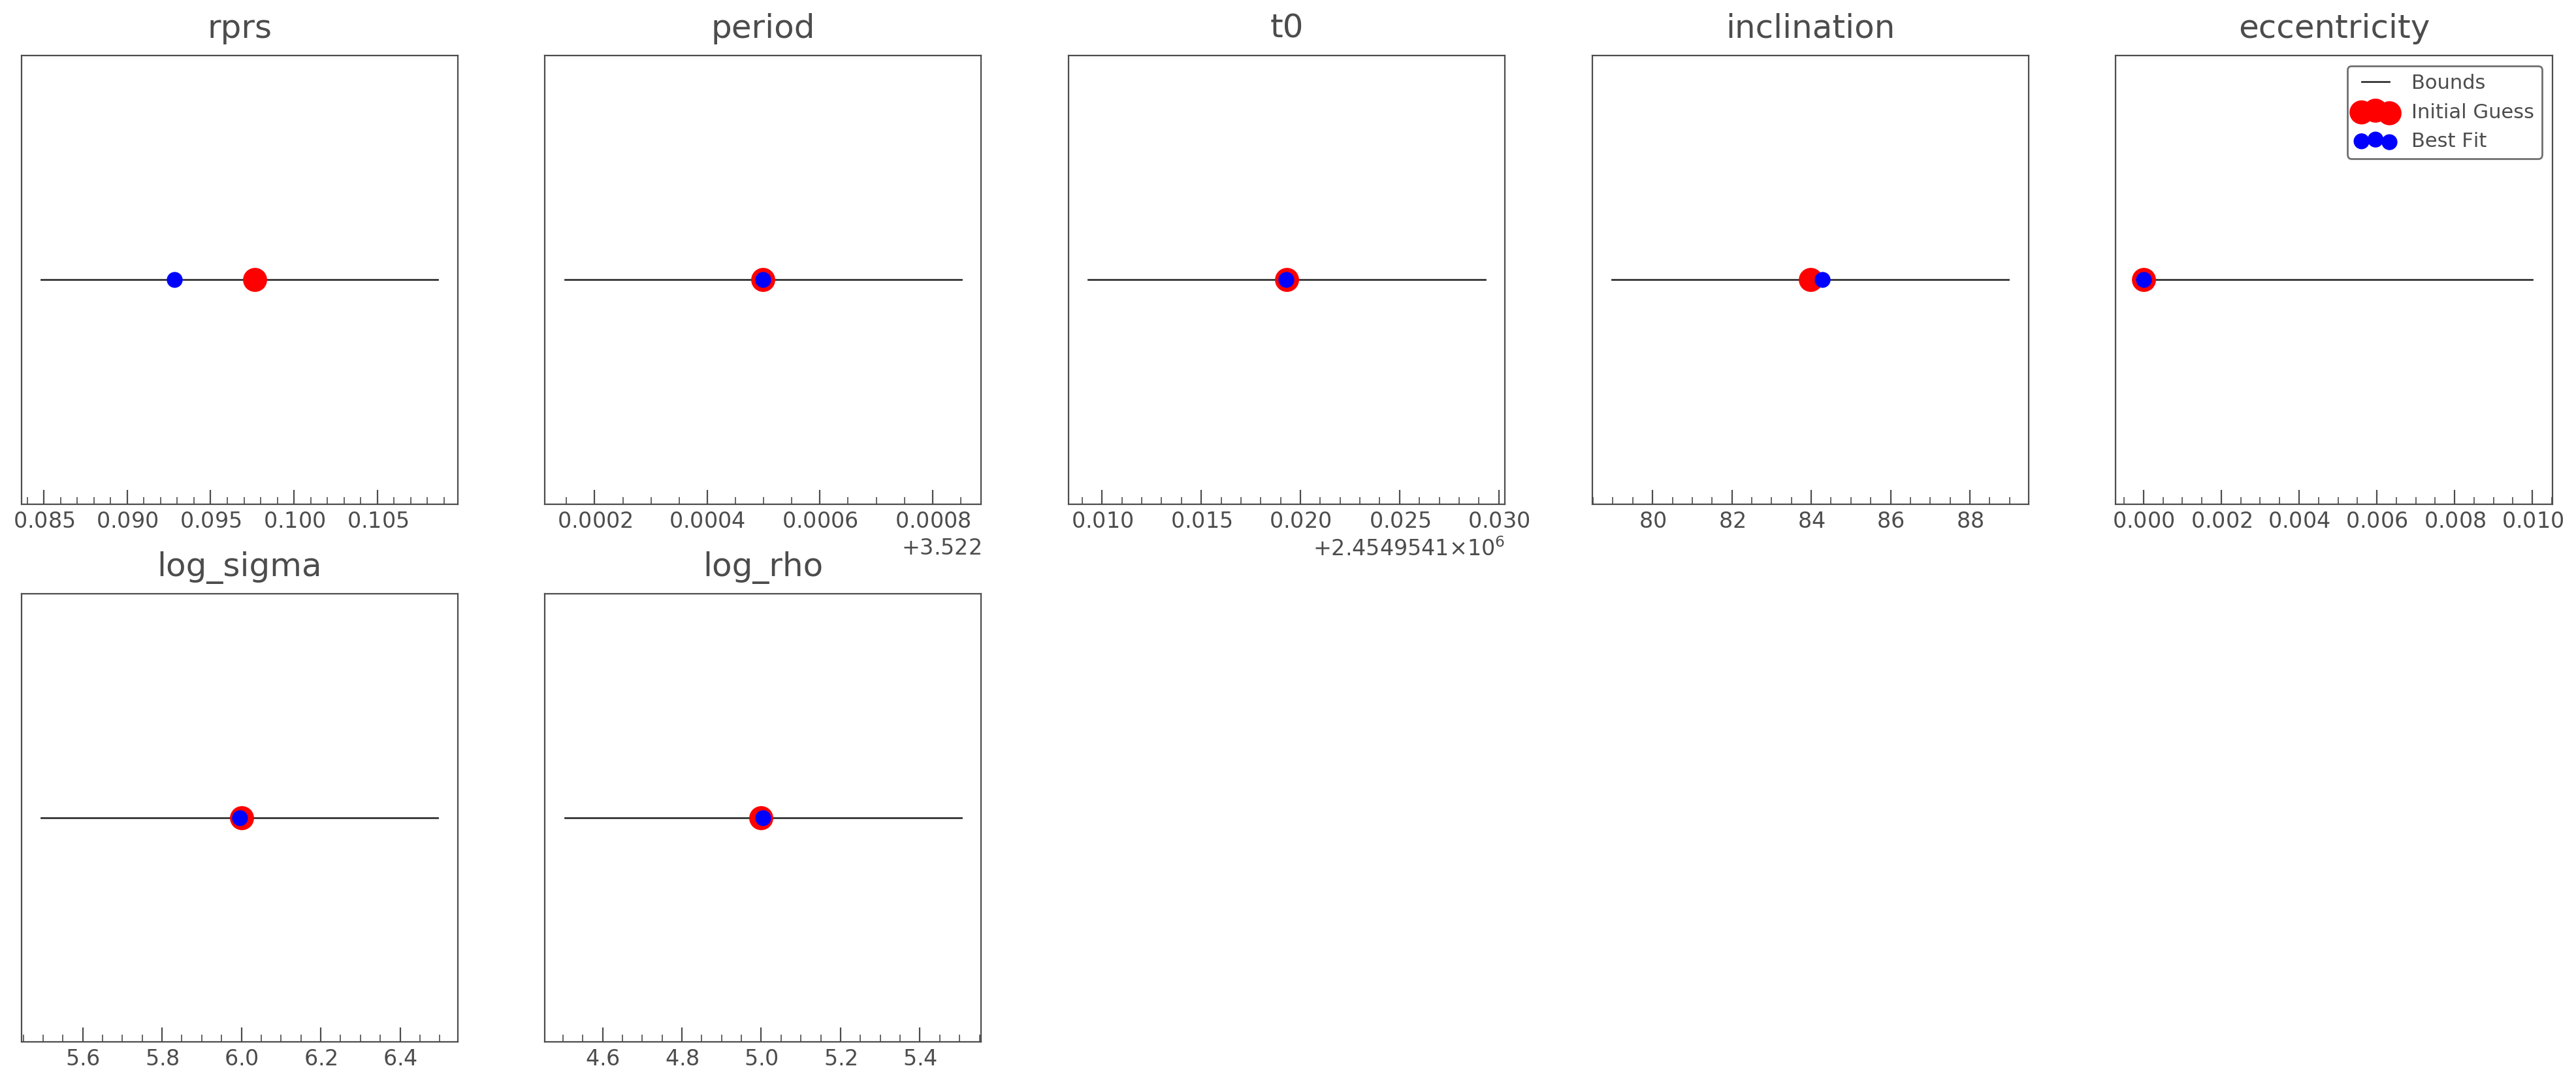

In [33]:
model.plot_results()

Let's plot the best fit model too. Note that when we use GPs, we have to pass the `compute()` method the flux and flux errors as well as the time, so we can train the GP model. Otherwise you're going to get a nice exception...

In [34]:
model.compute(lc.time)

ValueError: `flux` is None. When using GPs, compute must be passed the flux with errors.

In [35]:
model_flux = model.compute(lc.time, lc.flux, lc.flux_err)

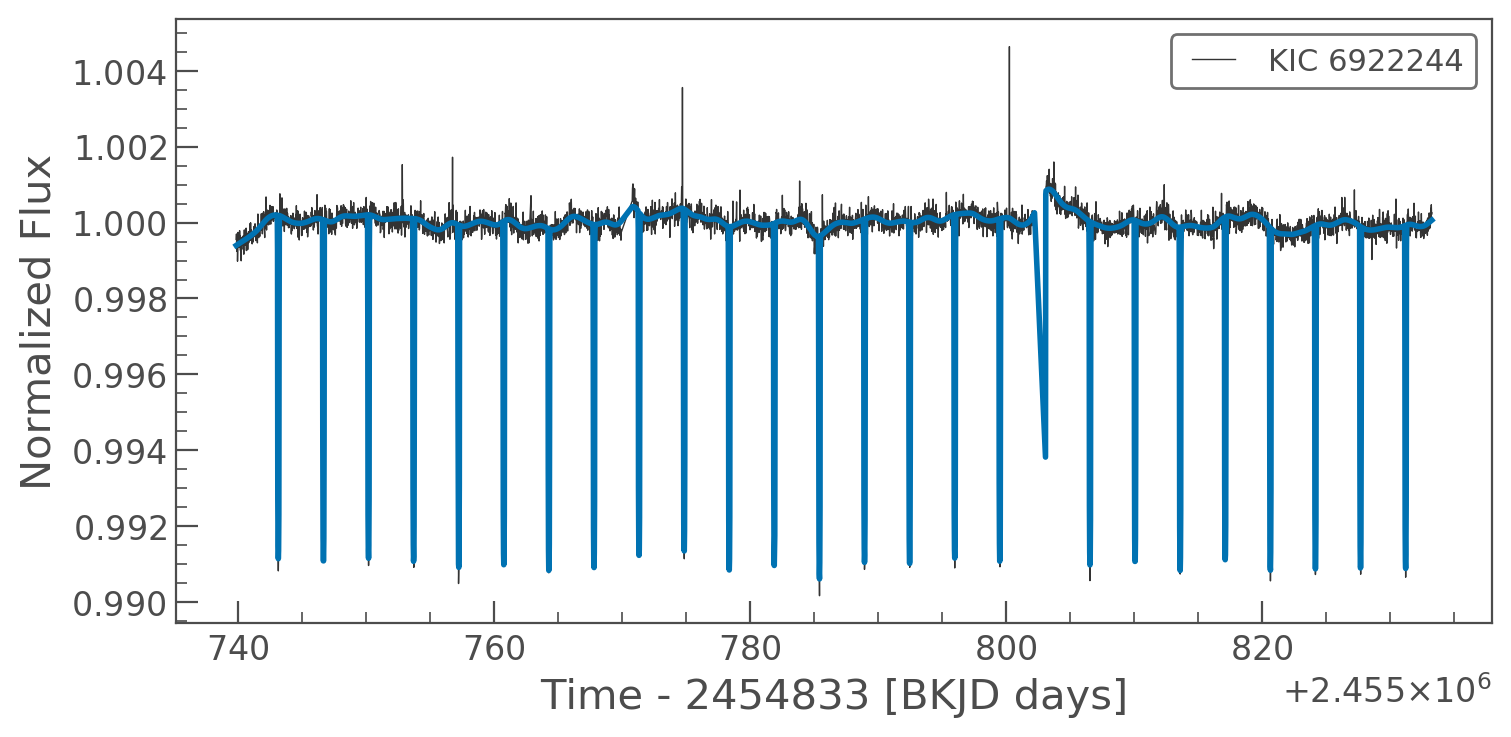

In [36]:
# The whole light curve
ax = lc.plot()
ax.plot(lc.time, model_flux, lw=2, label='Best Fit')